# Terea 1: Reconocedor basado en whisper

# Imports

In [1]:
import os
import torch
import torch, torchaudio, glob
import soundfile as sf
import numpy as np
import random
import scipy.signal
import csv
import matplotlib.pyplot as plt

from datasets import load_dataset
from IPython.display import Audio, display

/home/giuseppe/.pyenv/versions/hlt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Consts

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = 12
NB_EPOCHS = 3
BATCH_SIZE = 32

def seed_everything(seed):      
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

### Data Download

In [3]:
dataset = load_dataset("FluidInference/musan", split="train")

if not os.path.exists("musan_small"):
    os.makedirs("musan_small", exist_ok=True)
    for i, example in enumerate(dataset):
        audio = example["audio"]["array"]
        sr = example["audio"]["sampling_rate"]
        sf.write(f"musan_small/file_{i}.wav", audio, sr)
        
url = 'https://openslr.elda.org/resources/28/rirs_noises.zip'

if not os.path.exists('RIRS_NOISES'):
    if not os.path.exists('rirs_noises.zip'):
        os.system('wget ' + url)
    os.system('unzip -q rirs_noises.zip')
    os.system('rm rirs_noises.zip')

Repo card metadata block was not found. Setting CardData to empty.


## 1.1
Aprovechando lo visto en los cuadernos del taller se propone crear un tokenizador adaptado al vocabulario de la tarea. <br>
La idea es que sea orientado a palabra ya que hay pocas y simplifica el reconocimiento. <br> 
Se puede reaprovechar el tokenizador
DigitSumTokenizer que aparece en el cuaderno: parte2/run11. Implemente el
tokenizador para la tarea: <br>
- fechas2/fechas2_train.es.csv <br>
- fechas2/fechas2_test.es.csv <br>

In [4]:
class WordTokenizer:
    def __init__(self, csv_file):
        self.word2index = {
            '<pad>': 0,
            '<sos>': 1,
            '<eos>': 2,
            '<unk>': 3
        }
        self.index2word = {
            0: '<pad>',
            1: '<sos>',
            2: '<eos>',
            3: '<unk>'
        }

        self.build_vocab(csv_file)

    def build_vocab(self, csv_file):
        with open(csv_file, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                text = row['txt'].lower()
                for word in text.split():
                    if word not in self.word2index:
                        idx = len(self.word2index)
                        self.word2index[word] = idx
                        self.index2word[idx] = word

    def encode(self, text, seq_len=-1):
        tokens = ['<sos>'] + text.lower().split() + ['<eos>']
        ids = [
            self.word2index.get(w, self.word2index['<unk>'])
            for w in tokens
        ]

        if seq_len > len(ids):
            ids += [self.word2index['<pad>']] * (seq_len - len(ids))
        else:
            ids = ids[:seq_len]

        return torch.tensor(ids)


    def decode(self, ids):
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()

        words = [self.index2word.get(i, '<unk>') for i in ids]
        text = ' '.join(words)
        text = text.replace('<sos>', '').replace('<eos>', '').replace('<pad>', '')
        return text.strip()


## 1.2
Reutilice el contenido del cuaderno part1/run5 para implementar un Trainset y Testset adaptados a la tarea fechas2 que estamos implementando. <br> 
Compruebe de forma similar a como se hace en el cuaderno varios ficheros de train con aumento de ruido aditivo y reverberación con figuras de sus espectrogramas y la posibilidad de escucharlos.

#### Augmentation Functions

In [5]:
class NoiseAug(object):
    def __init__(self, noise_dir='musan_small/', prob=0.5):
        self.prob = prob
        self.noises = glob.glob(noise_dir + '*.wav')

        if len(self.noises) == 0:
            print("[WARN] No noise files found, NoiseAug disabled.")
            self.prob = 0.0

    def __call__(self, x):
        if len(self.noises) == 0:
            return x

        if np.random.uniform() < self.prob:
            n = torchaudio.load(np.random.choice(self.noises))[0][0]

            if len(n) < len(x):
                n = torch.nn.functional.pad(n, (0, len(x)-len(n)))
            elif len(n) > len(x):
                t0 = np.random.randint(0, len(n) - len(x))
                n = n[t0:t0+len(x)]

            n = n.numpy()
            snr = np.random.uniform(5, 15)
            n = n * np.sqrt(x.std()**2 / (n.std()**2 + 1e-8)) * 10**(-snr/20)
            x = x + n

        return x

    
class RIRAug(object):
    def __init__(self, rir_dir='RIRS_NOISES/simulated_rirs', prob=0.5):
        self.prob = prob
        self.rirs = glob.glob(rir_dir + '/*.wav')

        if len(self.rirs) == 0:
            print("[WARN] No RIR files found, RIRAug disabled.")
            self.prob = 0.0

    def __call__(self, x):
        if len(self.rirs) == 0:
            return x

        if np.random.uniform() < self.prob:
            n = len(x)
            rir = torchaudio.load(np.random.choice(self.rirs))[0][0]
            rir = rir.numpy()
            rir = rir / (np.max(np.abs(rir)) + 1e-8)
            x = scipy.signal.convolve(x, rir)
            t0 = np.argmax(np.abs(rir))
            x = x[t0:t0+n]

        return x

#### Dataset Definitions

In [6]:
def identity(x):
    return x

class TrainDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        tokenizer,
        audio_len=4*16000,
        seq_len=SEQ_LEN,
        transform=[identity]
    ):
        self.audio_len = audio_len
        self.seq_len = seq_len
        self.transform = transform
        self.tokenizer = tokenizer

        with open(csv_file, encoding='utf-8') as f:
            reader = csv.DictReader(f)
            self.data = [(row['wav'], row['txt']) for row in reader]

        print(len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav_path, text = self.data[idx]

        x, fs = torchaudio.load(wav_path)

        if x.shape[1] < self.audio_len:
            x = torch.nn.functional.pad(
                x, (0, self.audio_len - x.shape[1]), value=0
            )
        else:
            x = x[:, :self.audio_len]

        x = x[0].numpy()
        for t in self.transform:
            x = t(x)

        y = self.tokenizer.encode(text, self.seq_len)
        return x, y
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, tokenizer, audio_len=4*16000, seq_len=SEQ_LEN):
        self.audio_len = audio_len
        self.seq_len = seq_len
        self.tokenizer = tokenizer

        with open(csv_file, encoding='utf-8') as f:
            reader = csv.DictReader(f)
            self.data = [(row['wav'], row['txt']) for row in reader]

        print(len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav_path, text = self.data[idx]

        x, fs = torchaudio.load(wav_path)
        if x.shape[1] < self.audio_len:
            x = torch.nn.functional.pad(
                x, (0, self.audio_len - x.shape[1]), value=0
            )
        else:
            x = x[:, :self.audio_len]

        x = x[0]
        y = self.tokenizer.encode(text, self.seq_len)
        return x, y

In [7]:
tokenizer = WordTokenizer('fechas2/fechas2_train.es.csv')
tokenizer.build_vocab('fechas2/fechas2_test.es.csv')

trainset = TrainDataset(
    'fechas2/fechas2_train.es.csv',
    tokenizer,
    transform=[
        NoiseAug(prob=0.5),
        RIRAug(prob=0.5)
    ]
)

testset = TestDataset(
    'fechas2/fechas2_test.es.csv',
    tokenizer
)


[WARN] No RIR files found, RIRAug disabled.
10000
1000


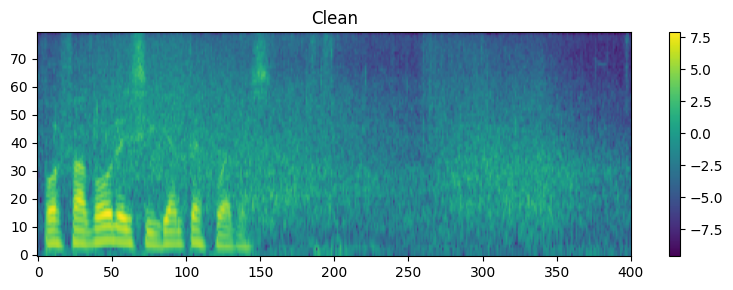

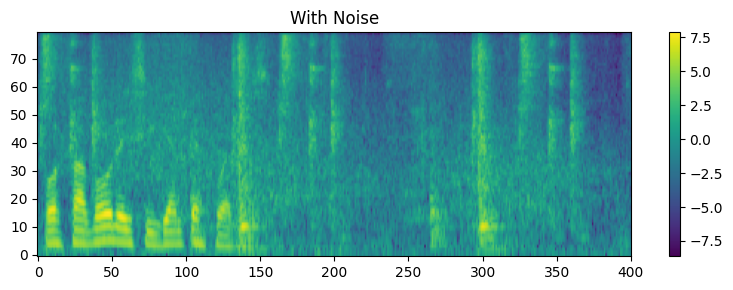

[WARN] No RIR files found, RIRAug disabled.


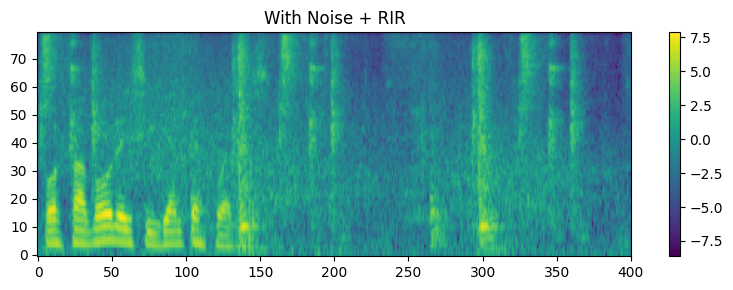

In [8]:
def plot_spectrogram(x, title):
    spec = torchaudio.transforms.MelSpectrogram(
        n_fft=512,
        win_length=25*16,
        hop_length=10*16,
        n_mels=80
    )(torch.tensor(x).unsqueeze(0))
    spec = (spec + 1e-6).log()[0].numpy()

    plt.figure(figsize=(8,3))
    plt.imshow(spec, origin='lower', aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


x, _ = trainset[0]

plot_spectrogram(x, "Clean")
display(Audio(x, rate=16000))

x_noise = NoiseAug(prob=1.0)(x.copy())
plot_spectrogram(x_noise, "With Noise")
display(Audio(x_noise, rate=16000))

x_noise_rir = RIRAug(prob=1.0)(x_noise.copy())
plot_spectrogram(x_noise_rir, "With Noise + RIR")
display(Audio(x_noise_rir, rate=16000))

## 1.3
Reutilice el tokenizador de la tarea 1.1, el trainset/testset de la tarea 1.2 y el contenido del cuaderno part3/run21 para implementar el entrenamiento y test de la tarea de fechas con los ficheros: fechas2_train.es.csv y fechas2_test.es.csv. <br>
Compruebe como se hace en el cuaderno la salida generada para algunos ejemplos de test y la visualización del modelo de atención y mida la tasa de error total WER en test. <br>
Si el modelo se entrena muy lento por falta de GPU no hace falta que se hagan muchas iteraciones completas de los datos, lo que se valora es el código. <br>
Puede usar también el frontend preentrenado que se muestra en el cuaderno parte3/run12 para mejorar las prestaciones.

In [9]:
class FeedForward(torch.nn.Module):
    def __init__(self, d_model=512, d_ff=1024, dropout=0.1, **kwargs):
        super().__init__()
        self.ff = torch.nn.Sequential(
            torch.nn.LayerNorm(d_model),
            torch.nn.Linear(d_model, d_ff),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(d_ff, d_model),
        )
        
    def forward(self, x):
        return self.ff(x)

class SelfAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, **kwargs):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)

    def forward(self, x):
        x = self.norm(x)
        b = x.shape[0]
        q = self.q_linear(x).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
     
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out

class Encoder(torch.nn.Module):
    def __init__(self, nb_layers=6, d_model=256, max_len=1000, **kwargs):
        super().__init__()
        self.pos = torch.nn.Parameter(torch.randn(1, max_len, d_model))
        self.att = torch.nn.ModuleList([SelfAttention(d_model=d_model, **kwargs) for _ in range(nb_layers)])
        self.ff = torch.nn.ModuleList([FeedForward(d_model=d_model, **kwargs) for _ in range(nb_layers)])
        
    def forward(self, x):
        b, t, d = x.shape
        x = x + self.pos[:, :t, :]
        for att, ff in zip(self.att, self.ff):
            x = x + att(x)
            x = x + ff(x)
        return x


class CausalSelfAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, **kwargs):
        super().__init__()
        self.seq_len = kwargs['seq_len']
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)
        
        self.register_buffer("mask", torch.tril(torch.ones(self.seq_len, self.seq_len))[None, None, ...] == 0)
            

    def forward(self, x):
        x = self.norm(x)
        b, n, d = x.shape
        q = self.q_linear(x).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
        
        scores = scores.masked_fill(self.mask[:,:,:n,:n], float('-inf'))
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out

class CrossAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, **kwargs):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)
    
    def forward(self, x1, x2):
        x1 = self.norm1(x1)
        x2 = self.norm2(x2)  
        b = x1.shape[0]
        q = self.q_linear(x1).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x2).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x2).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
     
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out, att
    
class Decoder(torch.nn.Module):
    def __init__(self, nb_layers=6, **kwargs):
        super().__init__()        
        self.seq_len = kwargs['seq_len']
        self.pos = torch.nn.Parameter(torch.randn(1, self.seq_len, kwargs['d_model']))
        self.att = torch.nn.ModuleList([CausalSelfAttention(**kwargs) for _ in range(nb_layers)])
        self.cross_att = torch.nn.ModuleList([CrossAttention(**kwargs) for _ in range(nb_layers)])
        self.ff = torch.nn.ModuleList([FeedForward(**kwargs) for _ in range(nb_layers)])
        
    def forward(self, x, enc):
        b, t, d = x.shape
        x = x + self.pos[:, :t, :]
        for att, cross_att, ff in zip(self.att, self.cross_att, self.ff):
            x = x + att(x)
            x = x + cross_att(x, enc)[0]
            x = x + ff(x)            
        return x

class SpecAug(torch.nn.Module):
    def __init__(self, prob_t_warp=0.5,
                       t_factor=(0.9, 1.1), 
                       f_mask_width = (0, 8), 
                       t_mask_width = (0, 10),
                       nb_f_masks=[1,2], 
                       nb_t_masks=[1,2] ):
        super().__init__()
        self.t_factor = t_factor
        self.f_mask_width = f_mask_width
        self.t_mask_width = t_mask_width
        self.nb_f_masks = nb_f_masks
        self.nb_t_masks = nb_t_masks
        self.prob_t_warp = prob_t_warp

    def time_warp(self, x):
        x = torch.nn.functional.interpolate(x, size=(int(x.shape[2]*np.random.uniform(*self.t_factor)), ))
        # print('warp', x.shape[2])
        return x
    
    def freq_mask(self, x):
        for _ in range(np.random.randint(*self.nb_f_masks)):
            f = np.random.randint(*self.f_mask_width)
            f0 = np.random.randint(0, x.shape[1]-f)
            # print('f', f0, f0+f)
            x[:,f0:f0+f,:] = 0
        return x

    def time_mask(self, x):
        for _ in range(np.random.randint(*self.nb_t_masks)):
            t = np.random.randint(*self.t_mask_width)
            t0 = np.random.randint(0, x.shape[2]-t)
            # print('t', t0, t0+t)
            x[:,:,t0:t0+t] = 0
        return x

    def forward(self, x):
        if np.random.uniform() < self.prob_t_warp:
            x = self.time_warp(x)
        x = self.freq_mask(x)
        x = self.time_mask(x)
        return x

In [10]:
class AudioFeatures(torch.nn.Module):
    def __init__(self, feat_dim=80, d_model=512, **kwargs):
        super().__init__()
        self.fe = torchaudio.transforms.MelSpectrogram(
                        n_fft=512, 
                        win_length=25*16, 
                        hop_length=10*16, 
                        n_mels=feat_dim)
        self.spec_aug = SpecAug()
        self.linear = torch.nn.Linear(feat_dim, d_model)

    def forward(self, x): 
        x = self.fe(x)        
        x = (x+1e-6).log()
        if self.training:
            x = self.spec_aug(x)
        x = x.transpose(1, 2)
        x = self.linear(x)
        return x

class AudioTransformer(torch.nn.Module):
    def __init__(self, vocab_size=24, **kwargs):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = kwargs['seq_len']

        self.fe = AudioFeatures(**kwargs)
        self.enc = Encoder(**kwargs)
        
        self.emb = torch.nn.Embedding(vocab_size, kwargs['d_model'])
        self.dec = Decoder(**kwargs)
        self.out = torch.nn.Linear(kwargs['d_model'], vocab_size)
        

    def encoder(self, x):
        x = self.fe(x)
        return self.enc(x)

    def decoder(self, y, enc):
        y = self.emb(y)
        dec = self.dec(y, enc)
        return self.out(dec)
    
    def forward(self, x, y):
        enc = self.encoder(x)
        return self.decoder(y, enc)
                    
    def loss(self, x, y, pad_idx=0):
        logits = self(x, y[:, :-1])
        target = y[:, 1:]

        loss = torch.nn.functional.cross_entropy(
            logits.reshape(-1, self.vocab_size),
            target.reshape(-1),
            ignore_index=pad_idx
        )
        return loss
    
           
    def generate(self, x, tokenizer):
        device = next(self.parameters()).device
        self.eval()

        sos = tokenizer.word2index['<sos>']
        eos = tokenizer.word2index['<eos>']

        y = [sos]

        with torch.no_grad():
            enc = self.encoder(x.to(device))

            while y[-1] != eos and len(y) < self.seq_len:
                y_tensor = torch.tensor(y).unsqueeze(0).to(device)
                logits = self.decoder(y_tensor, enc)
                next_token = logits.argmax(-1)[:, -1].item()
                y.append(next_token)

        return y
    

In [ ]:
vocab_size = len(tokenizer.word2index)

model = AudioTransformer(
    vocab_size=vocab_size,
    d_model=256,
    nb_layers=8,
    d_ff=512,
    n_heads=8,
    d_head=32,
    dropout=0.1,
    seq_len=SEQ_LEN
)

model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
model.train()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
for e in range(NB_EPOCHS):
    avg_loss = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        opt.zero_grad()
        pad_idx = tokenizer.word2index['<pad>']
        loss = model.loss(x, y, pad_idx=pad_idx)
        loss.backward()
        opt.step()
        avg_loss += loss.item()
    print('epoch %d/%d: avg_loss: %.2f' % (e,NB_EPOCHS,avg_loss/len(trainloader)))
       
torch.save([model, opt], 'model_es.pt')

In [ ]:
def wer(ref, hyp):
    ref = ref.split()
    hyp = hyp.split()

    d = np.zeros((len(ref)+1, len(hyp)+1), dtype=np.uint32)

    for i in range(len(ref)+1):
        d[i][0] = i
    for j in range(len(hyp)+1):
        d[0][j] = j

    for i in range(1, len(ref)+1):
        for j in range(1, len(hyp)+1):
            if ref[i-1] == hyp[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitute = d[i-1][j-1] + 1
                insert = d[i][j-1] + 1
                delete = d[i-1][j] + 1
                d[i][j] = min(substitute, insert, delete)

    return d[len(ref)][len(hyp)] / max(1, len(ref))

def evaluate_wer(model, dataset, tokenizer, device):
    total_wer = 0.0

    for i in range(len(dataset)):
        x, y = dataset[i]

        ref = tokenizer.decode(y)
        hyp_ids = model.generate(x.unsqueeze(0), tokenizer)
        hyp = tokenizer.decode(hyp_ids)

        total_wer += wer(ref, hyp)

    return total_wer / len(dataset)


In [ ]:
model, opt = torch.load(
    'model_es.pt',
    map_location=device,
    weights_only=False 
)

model.to(device)
model.eval()

In [ ]:
def show_test_examples(model, dataset, tokenizer, device, n=5):
    model.eval()

    for i in range(n):
        x, y = dataset[i]

        ref = tokenizer.decode(y)
        hyp_ids = model.generate(x.unsqueeze(0).to(device), tokenizer)
        hyp = tokenizer.decode(hyp_ids)

        print(f"Example {i+1}")
        print("REF:", ref)
        print("HYP:", hyp)
        print("-" * 40)

show_test_examples(model, testset, tokenizer, device, n=5)

In [ ]:
def get_attention(model, x, y):
    model.eval()
    with torch.no_grad():
        enc = model.encoder(x.unsqueeze(0).to(device))

        y_emb = model.emb(y.unsqueeze(0).to(device))
        x_dec = y_emb + model.dec.pos[:, :y_emb.size(1), :]

        att_weights = None
        for att, cross_att, ff in zip(
            model.dec.att,
            model.dec.cross_att,
            model.dec.ff
        ):
            x_dec = x_dec + att(x_dec)
            out, att_weights = cross_att(x_dec, enc)
            x_dec = x_dec + out
            x_dec = x_dec + ff(x_dec)

    return att_weights[0]  # [heads, tgt_len, src_len]

def plot_attention(att, tokenizer, hyp_tokens):
    att = att.mean(0).cpu().numpy()  # average over heads

    plt.figure(figsize=(10,4))
    plt.imshow(att, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel("Encoder time steps")
    plt.ylabel("Decoder tokens")
    plt.yticks(
        range(len(hyp_tokens)),
        [tokenizer.index2word[t] for t in hyp_tokens]
    )
    plt.title("Cross-Attention")
    plt.tight_layout()
    plt.show()

x, y = testset[random.randint(0, len(testset)-1)]

hyp_ids = model.generate(x.unsqueeze(0).to(device), tokenizer)
att = get_attention(model, x, torch.tensor(hyp_ids))

plot_attention(att, tokenizer, hyp_ids)

In [ ]:
wer_baseline = evaluate_wer(model, testset, tokenizer, device)
print(f"WER baseline:   {wer_baseline:.3f}")

In [ ]:
en_tokenizer = WordTokenizer('fechas2/fechas2_train.en.csv')
en_tokenizer.build_vocab('fechas2/fechas2_test.en.csv')

trainset_en = TrainDataset(
    'fechas2/fechas2_train.en.csv',
    en_tokenizer,
    transform=[
        NoiseAug(prob=0.5),
        RIRAug(prob=0.5)
    ]
)

testset_en = TestDataset(
    'fechas2/fechas2_test.en.csv',
    en_tokenizer
)

In [ ]:
en_vocab_size = len(en_tokenizer.word2index)

model_en = AudioTransformer(
    vocab_size=en_vocab_size,
    d_model=256,
    nb_layers=8,
    d_ff=512,
    n_heads=8,
    d_head=32,
    dropout=0.1,
    seq_len=SEQ_LEN
)

model_en.to(device)
opt_en = torch.optim.Adam(model_en.parameters(), lr=3e-4)
model_en.train()

trainloader_en = torch.utils.data.DataLoader(trainset_en, batch_size=BATCH_SIZE, shuffle=True)
for e in range(NB_EPOCHS):
    avg_loss = 0
    for x, y in trainloader_en:
        x = x.to(device)
        y = y.to(device)
        opt_en.zero_grad()
        pad_idx = en_tokenizer.word2index['<pad>']
        loss = model_en.loss(x, y, pad_idx=pad_idx)
        loss.backward()
        opt_en.step()
        avg_loss += loss.item()
    print('epoch %d/%d: avg_loss: %.2f' % (e,NB_EPOCHS,avg_loss/len(trainloader_en)))
       
torch.save([model_en, opt_en], 'model_en.pt')

In [ ]:
model_en, opt_en = torch.load(
    'model_en.pt',
    map_location=device,
    weights_only=False 
)

model_en.to(device)
model_en.eval()

In [ ]:
wer_baseline = evaluate_wer(model_en, testset_en, en_tokenizer, device)
print(f"WER baseline (English):   {wer_baseline:.3f}")